# Growth-limiting amino acids in commercial feed ingredients

Reproduces Fig. 5 and Fig. S5 of Zakhartsev et al. "SALARECON connects the Atlantic salmon genome to growth and feed efficiency" (2021).

## Feed protein and limiting amino acids

Protein is the most expensive component of salmon feed, and the efficiency varies with the composition of amino acids in the feed.  
Assuming the protein in fish feeds are fully degraded in the gut, and can be absorbed by the gut lining, the effect of amino acid composition is explored here.

## Identifying limiting amino acids in feeds

In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('..')


from matplotlib import rcParams
from os.path import join

from modules.amino_acid_analysis import *

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
plot_dir = '../../figures'
data_path = '../../data'
model_path = f'{data_path}/models'
sasa_path = '../../salarecon.xml'

Load salmon model and feed amino acid compositions from feedtables.org. 
Scale the feed ingredients so they sum to 1000 mg.
Divide the amount of glutamate/glutamine and apartate/asparagine by two, they will be picked up twice by the functions.

In [2]:
sasa = cobra.io.read_sbml_model(sasa_path)
for e in sasa.exchanges:
    e.lower_bound=-1000

In [3]:
feed_comp = pd.read_csv(f'{data_path}/feed_AA_composition.csv', index_col='AA')

feed_comp = 1000*feed_comp/feed_comp.sum()

feed_comp.T[['gln/glu','asn/asp']] = feed_comp.T[['gln/glu','asn/asp']]/2

## How to determine the limiting metabolite(s)  
The goal here is to determine which amino acids are limiting for growth, and in what order. 
We want to optimize the feed efficiency, meaning maximisation of $\frac{Biomass}{Feed\ uptake}$.  
That's not linear, so perhaps $Biomass - Feed\ uptake$ can be a substitute?  
This will also favor export of amino acids, so we need to distinguish between flux into the system and out of the system.  
This is acomplished by splitting the reversible exchange reactions into to irreversible reactions.  
Export of metabolites keeps the BiGG reaction id, while import gets '_rev' appended.
Fixing the growth rate and minimizing the mass of consumed amino acids could be an alternative, or perhaps maximation of Biomass is the best.  
###  Possible objectives and strategies:
## 1) $maximize(Biomass)$
The most common objective function, and most straight-forward to apply.  
- Set up bounds of AA-import based on the feed composition. 
The bounds are converted from mass ratio to molar ratio.
##### For each iteration:
    - optimize
    - identify limiting amino acid
    - open constraint (either by a set amount or entirely)
    - repeat

This is the simplest version to apply. 
However, it treats each molecule equally, and if we wish to minimize the mass of feed consumed, we may want to take the molar mass of the molecules into account.

## 2) $minimize(flux_{AA}*mass_{AA})$  
This method makes feed efficiency calculations easier, and it could easily be expanded to optimize combinations of feeds, and to take ingredient prices into account. 
- Fix the growth rate 
- Add a reaction representing the feed, with the correct molar ratio between aa's based on the mass ratio. 
- Set the import boundary of amino acids to 0.  
In this case, there will be an export of amino acids not utilized from the feed, in addition to amino acids produced by the model. 
Because of the antiport reactions transporting some amino acids between the environment and cytosol, there will in many cases be export of amino acids. 

##### For each iteration:
    - optimize
    - identify limiting amino acid
    - open constraint (either by a set amount or entirely)
    - repeat  

    
## 3) $maximize(Biomass \times 1000 - flux_{AA\ import} \times mass_{AA})$  
- split the aa-exchange reactions into an import and an export reaction
- set bounds for import based on feed
- set maximization of biomass - aa import as objective 
##### For each iteration:
    - optimize
    - identify limiting amino acid
    - Increase allowed uptake of the limiting amino acid (either by a set amount or entirely)
    - repeat  
    
### modification used later in this notebook:
- Start with biomass as objective
- optimize
- identify limiting AA
- increase allowed uptake of this AA, and close export
- include exchange of the limiting aa in the objective equation with a negative coefficient  

Export is banned to ommit this becoming the objective of the model.

## Which amino acids should we choose between?
In most cases, there are 20 amino acids used for protein. 
Should the amino acids considered be limited to these?  
The selection process can also obsured by amino acids that can be substituted by each other. 
This includes *methionine, precursor of cysteine* and *phenylalanine, precursor of tyrosine*. 
There may be energetic or economical reasons to add cysteine to the rather than methionine, but adding methionine seems like a "safer" bet since it has a larger set of possible routes.  
All 20 "standard" amino acids have been considered as the amino acids to choose from in this document.

A step further could be using prices of feed, supplement and fish as weights in the objective: 
$$ mass_{biomass} * price_{biomass} - mass_{feed} * price_{feed} - mass_{aa} * price_{aa} $$  
Or some quantification of the environmental impact.

## Should methionine be higher up on the list?
Methionine is often the most limiting amino acid, and it is a precursor for various molecules.  
### Taurine
The total amount of sulpur-containing amino acids is important for Taurine. 
How much taurine is to be expected in the biomass? 
Taurine is also an important vitamin, and is found in urine. 
Stricktly speaking, cysteine will give more taurine per gram (as cys is lighter), but cysteine is very reactive (will dimerize to cystine or other disulfide-compounds), so perhaps we are better off by replacing it with methionine? 

Ringvold et al reports taurine in salmon serum to be of a concentration twice that of alanine. try to add it in that ratio to the protein polymerization reaction?  

[Gormley et al](https://www.researchgate.net/publication/225609036_Taurine_content_of_raw_and_processed_fish_filletsportions) have quantified the taurine content in salmon filet to be 60 mg per 100 g wet weight. 
Using 0.35% as the dry matter conent, this equals 2.1 mg/gram dry weight, so about 0.017 mmol/g (coeficient in biomass reaction).
### Polyamines
Methionine is also a precursor for spermine and spermidine. 
With this in mind, the earlier biomass reaction contained the polyamines. 

### Methylation of DNA, Proteins and ...?
70% of cytosines are regarded to be methylated, so perhaps 20% of nucleotides. 
DNA is about 1.6% of our Biomass, so perhaps not a huge contribution. 
However, proteins are also methylated as part of post translational modifications, and proteins are over 50% of the biomass!  
To represent methylation, $SAM \rightarrow SAH$ is added to the DNA polymerization reaction. 
(amet_c and ahcys_c)

**That raises the question:** How many methylations on an average protein?  

### Methionine is much more essential in SBM than FM  
The main differences beween the order of AA essentiality for SBM and FM seems to be that lysine and methionine are in higher demand in SBM, while they are very low on the list for FM.   

# Taking mass and cost of supplements into the equation 
Redefining two of the functions used...  

Here, limited metabolites are determined by $\frac{reduced\ cost}{molar\ mass}$, to determine the cost based on mass rather than mol. 

Exchange reactions for the limiting amino acids are also added to the objective function iteratively.  
Since this method penalizes negative flux of AA-exchange reactions, production and excretion of non-essential amino acids can be expected eventually. 
This could be tackled by defining import and export independently (using OØs `mptool.make_irreversible_cobra`, for instance), but this would require a lot of changes to the code, so to begin with, when added to the list of limiting amino acids (and to the objective), export of the amino acid is forbidden.

## Figures for publication, including Black Soldier Fly

..\modules\amino_acid_analysis.py:683 UserWarning: FixedFormatter should only be used together with FixedLocator
..\modules\amino_acid_analysis.py:683 UserWarning: FixedFormatter should only be used together with FixedLocator
..\modules\amino_acid_analysis.py:683 UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


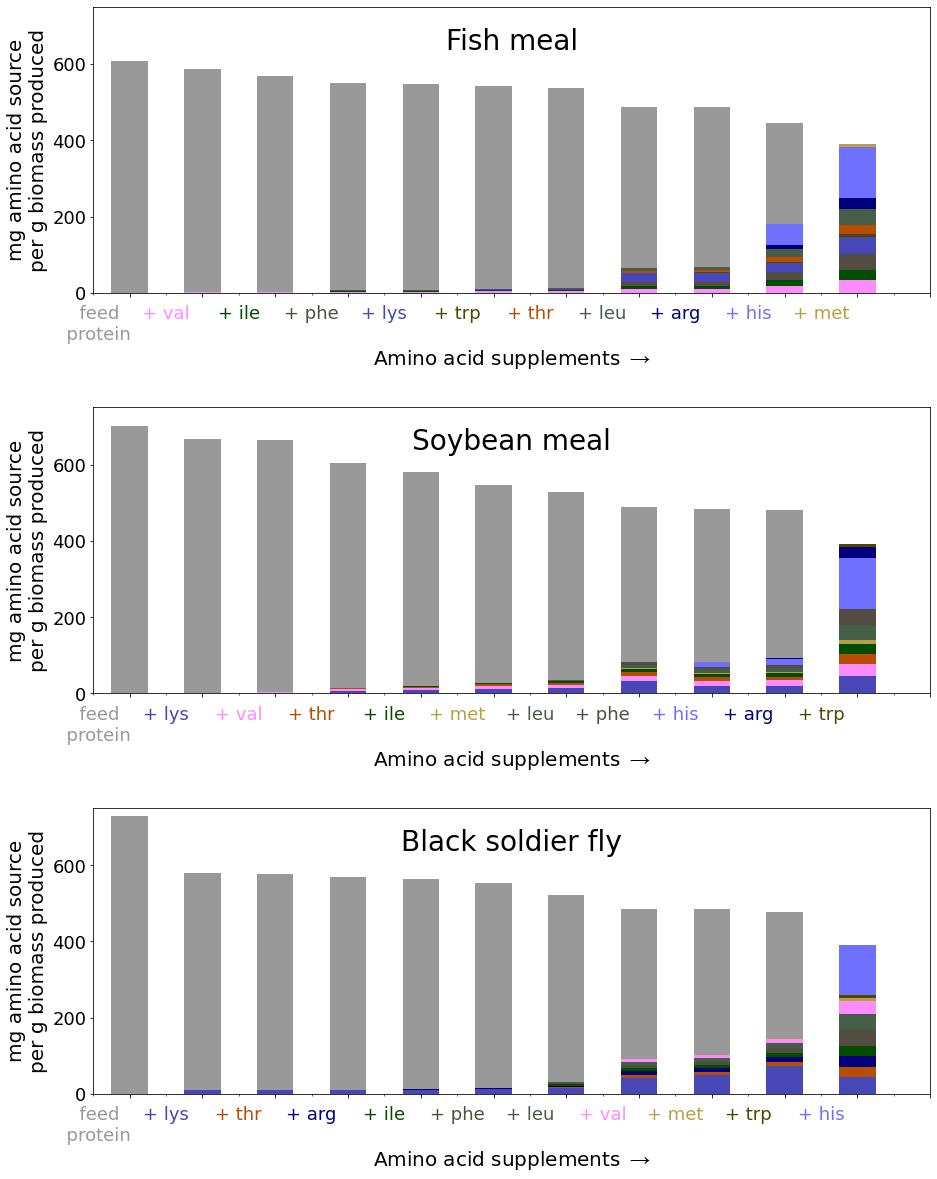

In [4]:
feed_names = {'BSF': 'Black soldier fly', 'FM': 'Fish meal', 'SBM': 'Soybean meal'}
lim_order = dict()
lim_value = dict()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,20))
n = 10
step = 1
spmdlb = 0.04/sasa.metabolites.spmd_c.formula_weight
taurdm = 2.1/sasa.metabolites.taur_c.formula_weight
cyt_coef = 1
glc_mass = 600
glc_coef = 1000
carbon = False
axlist = [ax1,ax2,ax3]
axlist.reverse()
for name, comp in feed_comp[['FM', 'SBM', 'BSF']].iteritems():
    axs = axlist.pop()
    with sasa as model:
        model.add_boundary(model.metabolites.glc__D_c, type="sink", lb=-glc_coef, ub=1000)
        model.add_boundary(model.metabolites.spmd_c, type="sink", lb=spmdlb, ub=1000)
        model.reactions.Biomass.add_metabolites({model.metabolites.taur_c: taurdm})
        model.reactions.DNA_biomass.add_metabolites({model.metabolites.get_by_id('amet_c'): cyt_coef*0.7, 
                                                     model.metabolites.get_by_id('ahcys_c'): -cyt_coef*0.7})
        sols = simulation_list(model=model, n=n, feed=comp, enable_carbon=carbon, step_size=step)
        plot_feed_efficiency(sols, 
                             model, 
                             ax=axs,
                             title=feed_names[name])
        lim_order[name] = [aa.split('_')[1] for aa in sols.keys()]
        lim_value[name] = [np.abs(sol.objective_value) for _, sol in sols.items()]
for ax in (ax1, ax2, ax3):
    ax.set_ylim(0,750)
plt.subplots_adjust(hspace=0.4)
fig.savefig(join(plot_dir, 'lim_aa.svg'), bbox_inches='tight')

In [5]:
pd.DataFrame(lim_order).to_csv(f'{data_path}/lim_aa_order.csv')

In [6]:
pd.DataFrame(lim_value).to_csv(f'{data_path}/lim_aa_feed_efficiency.csv')

In [7]:
# The last element of each list of limiting amino acids is cysteine, and is not limiting for growth. 
# Therefore removing it
for d in lim_order.values():
    d.pop()

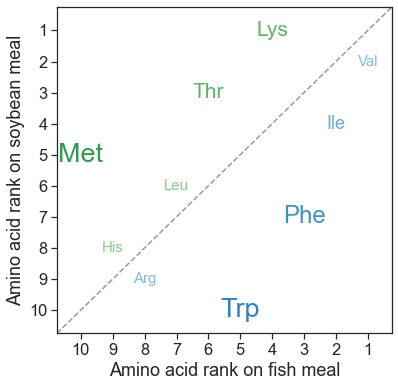

In [8]:
lim_fm_sbm = pd.DataFrame({aa.capitalize(): (x, np.where(pd.Series(lim_order['SBM'])==aa)[0][0])
              for x, aa in enumerate(lim_order['FM'])}, index=['FM','SBM']).T + 1
blues = sns.color_palette('Blues', 15)[-10:]
greens = sns.color_palette('Greens', 15)[-10:]
c = lim_fm_sbm['FM'] - lim_fm_sbm['SBM']
s = c.abs() * 3 + 12
lim_fm_sbm['c'] = [blues[-val] if val < 0 else greens[val] for val in c]
lim_fm_sbm['s'] = s
lim_fm_sbm

sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots()

xlim = ylim = len(lim_fm_sbm) + 0.75, 0.25
ax.plot(xlim, ylim, c='#999999', ls='--')
lim_fm_sbm.plot.scatter('FM','SBM', ax=ax, c='#FFFFFF')
for row, (x, y, c, s) in lim_fm_sbm.iterrows():
    ax.annotate(row, (x, y), ha='center', va='center', 
                fontsize=s, 
                c=c
               )
plt.xlabel('Amino acid rank on fish meal')
plt.ylabel('Amino acid rank on soybean meal')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks([i + 1 for i in range(len(lim_fm_sbm))])
plt.yticks([i + 1 for i in range(len(lim_fm_sbm))] )
plt.grid(True, ls='--')
plt.grid(False)
fig.set_size_inches(6, 6)
fig.savefig(join(plot_dir, 'rank_diff_sbm.svg'), bbox_inches='tight')

In [9]:
fm_sbm = dict()

In [10]:
lim_fm_sbm = pd.DataFrame({aa.capitalize(): (x, np.where(pd.Series(lim_order['BSF'])==aa)[0][0])
              for x, aa in enumerate(lim_order['FM'])}, index=['FM','BSF']).T + 1
blues = sns.color_palette('Blues', 15)[-10:]
greens = sns.color_palette('Oranges', 15)[-10:]
c = lim_fm_sbm['FM'] - lim_fm_sbm['BSF']
s = c.abs() * 3 + 12
lim_fm_sbm['c'] = [blues[-val] if val < 0 else greens[val] for val in c]
lim_fm_sbm['s'] = s
lim_fm_sbm
sns.set(style='ticks', font_scale=1.5)

fig, ax = plt.subplots()

xlim = ylim = len(lim_fm_sbm) + 0.75, 0.25
ax.plot(xlim, ylim, c='#999999', ls='--')
lim_fm_sbm.plot.scatter('FM','BSF', ax=ax, c='#FFFFFF')
for row, (x, y, c, s) in lim_fm_sbm.iterrows():
    ax.annotate(row, (x, y), ha='center', va='center', 
                fontsize=s, 
                c=c
               )
plt.xlabel('Amino acid rank on fish meal')
plt.ylabel('Amino acid rank on soybean meal')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks([i + 1 for i in range(len(lim_fm_sbm))])
plt.yticks([i + 1 for i in range(len(lim_fm_sbm))] )
plt.grid(True, ls='--')
plt.grid(False)
fig.set_size_inches(6, 6)
fig.savefig(join(plot_dir, 'rank_diff_bsf.svg'), bbox_inches='tight')

In [11]:
dfs = [pd.read_csv(f'{data_path}/lim_aa_order.csv', index_col=0).melt(),
       pd.read_csv(f'{data_path}/lim_aa_feed_efficiency.csv', index_col=0).melt().iloc[:, 1:]]
df = pd.concat(dfs, 1)
df.columns = ['feed', 'aa', 'eff']
df['aa'] = df.aa.str.capitalize()
df['rank'] = np.tile(range(1, int(len(df) / 3) + 1), 3)
df['eff'] = 1 / df.eff
eff_df = df.copy()

In [12]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

xlim = -0.5, 10.5

p = ['#377eb8', '#4daf4a', '#ff7f00']

df = eff_df
df = df[df['rank'] < 12]
ax = sns.lineplot(x=df['rank'] - 1, y=df['eff'], hue=df.feed, style=df.feed, palette=p, markers=['o'] * 3, dashes=False, lw=2, ms=12)
plt.plot(xlim, [df[df.feed == 'FM'].eff.min()] * 2, c=p[0], ls='--')

plt.fill_between(xlim, 1.17, 1.65, color='#f0f0f0', zorder=-1)
plt.fill_between(xlim, 1 / 0.76, 1 / 0.65, color='#d9d9d9', zorder=-1)
plt.text(8.2, 1.24, 'Kolstad (2004)', c='k', va='center')
plt.text(8.2, 1.4, 'Dvergedal (2019)', c='k', va='center',)

h, l = ax.get_legend_handles_labels()
plt.legend(h, ['Fish meal', 'Soybean meal', 'Insect meal'], title=None)

plt.xlabel('Number of supplemented amino acids')
plt.ylabel('Feed efficiency (g biomass / g feed)')
plt.xticks(range(len(df)))
plt.xlim(xlim)
plt.grid(True, ls='--')

f.set_size_inches(14, 6)
f.savefig(join(plot_dir, 'rank_feed_eff.svg'), bbox_inches='tight')

In [13]:
# Get feed compositions as mass percentage
df = feed_comp.copy()
df.loc[['gln/glu','asn/asp']] *= 2
df /= 10

df = df.reset_index().melt(id_vars='AA', var_name='source', value_name='percent')
df.columns = [x.lower() for x in df.columns]
df.aa = df.aa.str.capitalize()
df.aa = [x.replace('Gln/glu', 'Glu/Gln').replace('Asn/asp', 'Asn/Asp') for x in df.aa]

df.groupby('source').percent.sum()
df

aa source    percent
0       Lys     FM   8.311229
1       Thr     FM   4.568229
2       Met     FM   3.065134
3       Cys     FM   0.928382
4       Trp     FM   1.134689
5       Ile     FM   4.641910
6       Val     FM   5.481874
7       Leu     FM   7.913351
8       Phe     FM   4.288240
9       Tyr     FM   3.404067
10      His     FM   2.623047
11      Arg     FM   7.191276
12      Ala     FM   6.822871
13  Asn/Asp     FM  10.020631
14  Glu/Gln     FM  13.984674
15      Gly     FM   6.881816
16      Ser     FM   4.288240
17      Pro     FM   4.450339
18      Lys    SBM   6.442131
19      Thr    SBM   3.674219
20      Met    SBM   1.445193
21      Cys    SBM   1.739130
22      Trp    SBM   1.579914
23      Ile    SBM   4.605021
24      Val    SBM   4.996938
25      Leu    SBM   8.022045
26      Phe    SBM   5.217391
27      Tyr    SBM   3.600735
28      His    SBM   2.694427
29      Arg    SBM   7.544397
30      Ala    SBM   4.433558
31  Asn/Asp    SBM  11.867728
32  Glu/Gln    SBM  18.738518
33      Gly    SBM   4.188610
34      Ser    SBM   4.127373
35      Pro    SBM   5.082670
36      Lys    BSF   6.194163
37      Thr    BSF   4.288267
38      Met    BSF   2.064721
39      Cys    BSF   0.615446
40      Trp    BSF   1.608100
41      Ile    BSF   4.864006
42      Val    BSF   6.789756
43      Leu    BSF   7.762557
44      Phe    BSF   4.308120
45      Tyr    BSF   6.849315
46      His    BSF   3.315466
47      Arg    BSF   5.340480
48      Ala    BSF   7.047846
49  Asn/Asp    BSF  10.065515
50  Glu/Gln    BSF  11.117729
51      Gly    BSF   6.670637
52      Ser    BSF   4.705182
53      Pro    BSF   6.392694

In [14]:
# Load biomass composition
bm_df = pd.read_csv(f'{data_path}/salarecon_biomass.csv', index_col=0)

# Remove non-protein components and abbreviate AAs
bm_df = bm_df[bm_df.component=='Protein']
bm_df = bm_df[:20]
bm_df['aa'] = [x[:3].replace('Try', 'Trp').replace('Iso', 'Ile') for x in bm_df.metabolite]

# Convert coefficents from moles to mass
c = []
for i, row in bm_df.iterrows():
    try:
        m = sasa.metabolites.get_by_id(row.aa.lower() + '__L_c')
    except KeyError:
        m = sasa.metabolites.get_by_id(row.aa.lower() + '_c')
    c.append(row.coefficient * m.formula_weight)
bm_df.coefficient = c

# Calculate mass percentage and format data
bm_df['percent'] = bm_df.coefficient / bm_df.coefficient.sum() * 100
bm_df['source'] = 'Biomass'
bm_df = bm_df[['aa', 'percent', 'source']]
bm_df = bm_df.append(pd.DataFrame({'aa': ['Asn/Asp', 'Glu/Gln'], 'percent': [bm_df[bm_df.aa.isin(['Asp', 'Asn'])].percent.sum(), bm_df[bm_df.aa.isin(['Glu', 'Gln'])].percent.sum()], 'source': ['Biomass'] * 2}))
bm_df = bm_df[~bm_df.aa.isin(['Asp', 'Asn', 'Glu', 'Gln'])].reset_index(drop=True)

bm_df

aa    percent   source
0       Cys   0.181812  Biomass
1       Trp   1.225852  Biomass
2       Met   1.626282  Biomass
3       His   2.193475  Biomass
4       Tyr   3.963926  Biomass
5       Phe   4.748953  Biomass
6       Arg   6.047176  Biomass
7       Pro   4.073646  Biomass
8       Ser   4.166686  Biomass
9       Thr   4.873337  Biomass
10      Ile   5.428633  Biomass
11      Val   6.652313  Biomass
12      Lys   9.021345  Biomass
13      Gly   4.665912  Biomass
14      Leu   8.319070  Biomass
15      Ala   8.760499  Biomass
16  Asn/Asp  11.298714  Biomass
17  Glu/Gln  12.752370  Biomass

In [15]:
# Combine feed and biomass compositions
df = df.append(bm_df).reset_index(drop=True)

In [16]:
# Plot mass percentage of amino acids in biomass and feed
sns.set(style='ticks', font_scale=1.5)

f = plt.figure()

order = df.groupby('aa').percent.mean().sort_values(ascending=False).index
hue_order = ['Biomass', 'FM', 'SBM', 'BSF']

ax = sns.barplot(y='aa', x='percent', hue='source', data=df, palette=['#e41a1c'] + p, order=order, hue_order=hue_order)

plt.ylabel('')
plt.xlabel('Mass percentage of protein')
plt.xlim(0, 20)
plt.grid(True, axis='x', ls='--')

# ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
h, l = ax.get_legend_handles_labels()
plt.legend(h, ['Biomass', 'Fish meal', 'Soybean meal', 'Insect meal'], title=None)

f.set_size_inches(4, 13)
f.savefig(join(plot_dir, 'aa_mass_percent.svg'), bbox_inches='tight')